In [1]:
import imageio as im 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Neural_Network:
    """
    A class used to represent a Neural Network with three layers:
        Input layer, Hidden layer, Output layer

    Data Attributes
    ----------
    i_nodes : int
        number of nodes in the input layer of the network
    h_nodes : int
        number of nodes in the hidden layer of the network
    o_nodes : int
        number of nodes in the output layer of the network
    Activation: class
        a class that represents an activation function
        the class should have two methods:
            1. func: the activation function
            2. der: the derivative of the activation function

    Methods
    -------
    foward_propagation(inputs_list)
        Parameters
        ----------
        inputs_list: features of a dataset
        
        returns:
            inputs as a transposed 2D numpy array, 
            hidden_outputs:
              a dot product of input_hidden_layer weights and inputs
              the dot product is passed through an activation function
            final_outputs:
                a dot product of hidden_output_layer weights and hidden_outputs
                the dot product is passed through an activation function
    
    backward_propagation(inputs_list, targets_list,lr)
        Parameters
        ----------
        inputs_list:  features of a dataset
        targets_list: desired values to be predicted
        lr: learning rate of network
        
        Uses gradient descent to refine weights of the network
    
    reset_weights:
       Resets weights of a neural network
    
    """
    
    def __init__(self,i_nodes, h_nodes, o_nodes, Activation):
        #set number of node in each input
        self.i_nodes = i_nodes
        self.h_nodes = h_nodes
        self.o_nodes = o_nodes
        
        # weights inside the arrays are w_i_j, where link is from node i to node j in the next layer
        # 
        # w_ih: link weight matrix between input and hidden layer,  
        self.w_ih = np.random.normal(0.0,pow(self.h_nodes, -0.5),(self.h_nodes,self.i_nodes)) 
        # w_ho: link weight matrix between hidden layer and output layer,  
        self.w_oh = np.random.normal(0.0,pow(self.o_nodes, -0.5),(self.o_nodes,self.h_nodes)) 
        
        # activation function:
        self.activation = Activation()
        
    def foward_propagation(self,inputs_list):
        #convert inputs to a 2D array
        inputs = np.array(inputs_list, ndmin=2).T
        
        #compress inputs
        output_func = lambda w, x: self.activation.func(np.dot(w, x))

        #calculate signals emerging from the hidden layer
        hidden_outputs = output_func(self.w_ih, inputs)

        #calculate signals emerging from the final output layer
        final_outputs =  output_func(self.w_oh,hidden_outputs)

        return inputs, hidden_outputs, final_outputs
    
    def backward_propagation(self, inputs_list, targets_list,lr):
        #return final output of signals
        inputs,hidden_outputs, final_outputs = self.foward_propagation(inputs_list)
        
        final_inputs = np.dot(self.w_oh,hidden_outputs)
        
        hidden_inputs = np.dot(self.w_ih, inputs)
        
        #convert targets to a 2D array
        targets = np.array(targets_list, ndmin=2).T
        
        #output layer error = target - final_outputs
        output_errors = targets - final_outputs
        
        # hidden layer error = output_errors, split by weights, recombined at hidden nodes
        hidden_errors = np.dot(self.w_oh.T, output_errors)
        
        update_weights = lambda err, y, x: lr*np.dot(err*self.activation.der(y), x.T)

        #For weights between output layer and hidden layer use output_errors
        #update the weights for the links between the hidden and output layers
        self.w_oh += update_weights(output_errors,final_inputs,hidden_outputs)
        
        #For weights between hidden layer and input layer use input_errors
        #update the weights for the links between the input and hidden layers
        self.w_ih += update_weights(hidden_errors,hidden_inputs,inputs)
        
    def reset_weights(self):
        # w_ih: link weight matrix between input and hidden layer,  
        self.w_ih = np.random.normal(0.0,pow(self.h_nodes, -0.5),(self.h_nodes,self.i_nodes)) 
        # w_ho: link weight matrix between hidden layer and output layer,  
        self.w_oh = np.random.normal(0.0,pow(self.o_nodes, -0.5),(self.o_nodes,self.h_nodes)) 

In [3]:
# Activation function used in the neural network
class Sigmoid:
    def func(self, x):
        return 1/(1+np.exp(-x))
    
    def der(self, x):
        return self.func(x)*(1 - self.func(x))

In [4]:
#read mnist train
path_train = "mnist_dataset/mnist_train.csv"
with open(path_train) as f:
    mnist_train = list(f)
    
#read mnist test 
path_test = "mnist_dataset/mnist_test.csv"
with open(path_test) as f:
    mnist_test = list(f)

In [5]:
# functions that prepare mnist dataset 

# convert csv into float array and exlcude first element
str_to_arr =  lambda s: np.asfarray(s.split(',')[1:])

# rescale the inputs (0,255) to (0.01, 0.99)
rescale_inputs = lambda i: str_to_arr(i)*(0.98/255) + 0.01

# create target output values: 0.99 for true value else 0.01
def rescale_outputs(record,nodes):
    outputs = np.ones(nodes)*0.01
    outputs[int(record[0])] = 0.99
    
    return outputs


In [6]:
# inputs nodes are pixel values of each digit: 28 * 28 = 784
i_nodes = 784 
#hidden nodes are chosen arbitrarily
h_nodes = 100
#output nodes are 10: 0 to 9
o_nodes = 10

# create instance of neural network
mnist_nn = Neural_Network(i_nodes,h_nodes,o_nodes, Sigmoid)

In [7]:
# function that trains network
def train(network, epochs, l_rate):
    for epoch in range(epochs):
        for record in mnist_train:
            inputs = rescale_inputs(record)
            targets = rescale_outputs(record,o_nodes)
            network.backward_propagation(inputs, targets,l_rate) 

In [8]:
epochs, l_rate  = 1, 0.1
train(mnist_nn, epochs, l_rate)
epochs, l_rate  = 1, 0.05
train(mnist_nn, epochs, l_rate)

In [9]:
#test the network
#scorecard of how well network performs
scorecard = []

for record in mnist_test:
    correct_label = int(record.split(',')[0])
    # print(f'correct label: {correct_label}')
    prediction = mnist_nn.foward_propagation(rescale_inputs(record))[2].flatten().argmax()
    # print(f'predicted label: {prediction}')
    # print('---')
    scorecard.append(correct_label==prediction)

perc = np.count_nonzero(scorecard) / len(scorecard) *100

print(f'Correct predictions: {np.count_nonzero(scorecard)}')
print(f'Incorrect predictions: {np.count_nonzero(np.invert(scorecard))}')
print(f'Performance: {perc:.2f}%')
print(f'Error: {100 - perc:.2f}%')

Correct predictions: 9611
Incorrect predictions: 389
Performance: 96.11%
Error: 3.89%


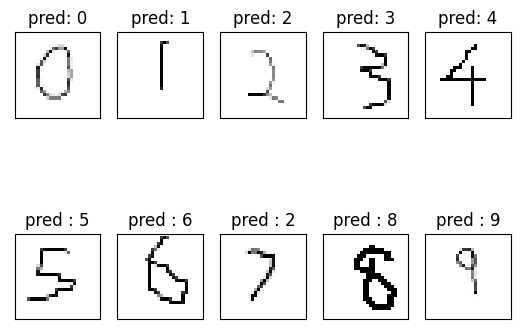

In [10]:
fig, axes =  fig, axes = plt.subplots(2, 5)
digits = ['zero','one','two','three', 'four','five','six','seven','eight','nine']


for i in range(len(digits)):
    img_array = im.v2.imread(f'imgs/{digits[i]}.png',as_gray=True)
    img_data = 255.0 - img_array.reshape(784)
    img_data = (img_data/255 * 0.98) + 0.01
    if i <= 4: 
        axes[0, i].imshow(img_data.reshape(28,28), cmap='Greys', interpolation='None')
        axes[0,i].set_title(f'pred: {mnist_nn.foward_propagation(img_data)[2].flatten().argmax()}')
        axes[0,i].set_xticks([])
        axes[0,i].set_yticks([])
    else:
        axes[1, i-5].imshow(img_data.reshape(28,28), cmap='Greys', interpolation='None')
        axes[1,i-5].set_title(f'pred : {mnist_nn.foward_propagation(img_data)[2].flatten().argmax()}')
        axes[1,i-5].set_xticks([])
        axes[1,i-5].set_yticks([])